In [1]:
import os, sys
import pandas as pd
import numpy as np
import glob
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools
from tqdm.auto import tqdm
from multiprocessing import Pool
from stargazer.stargazer import Stargazer
from stargazer_mod import Stargazer as S_alt
from adjustText import adjust_text
import ipywidgets as widgets
import itertools
import copy

sns.set_context("paper", font_scale=1.7)

# Load Data

<AxesSubplot:xlabel='datetime'>

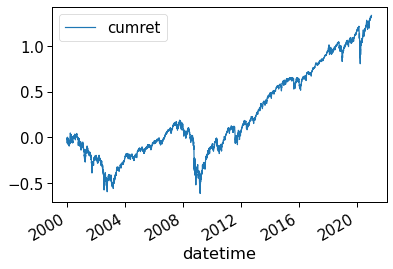

In [2]:
# Data for just SPY
daily_df = pd.read_feather('../../data/proc/SPY_daily.feather')

# Clean?
daily_df = daily_df.sort_values(by = ['datetime'])

# Check
daily_df.assign(cumret = daily_df['log_return'].cumsum()).plot('datetime', 'cumret')

# Analyze

In [3]:
## Add regression variables

# Rename
daily_df['SJ_vol'] =  daily_df['real_vol_pos'] - daily_df['real_vol_neg']

# Differences
daily_df = daily_df.sort_values(by = 'datetime') 
for col in ['real_var', 'real_var_pos', 'real_var_neg', 'SJ', 'real_vol', 'real_vol_pos', 'real_vol_neg', 'SJ_vol']:
    daily_df[f'{col}_diff'] = daily_df[f'{col}'].diff(1)

## Daily Regressions (Main)

In [4]:
## Regression functions

def add_smooth_return(daily_df, window):
    
    daily_df['log_return_rolling'] = daily_df.groupby(['permno'])['log_return'].transform(
        lambda x: x.rolling(window, min_periods = window).mean())
    daily_df['log_return_rolling_lead'] = daily_df.groupby(['permno'])['log_return_rolling'].transform(
        lambda x: x.shift(-window))
    
    return daily_df

def add_smooth_regressor(daily_df, window, regressor):
    
    daily_df[f'{regressor}_rolling_mean'] = daily_df.groupby(['permno'])[regressor].transform(
        lambda x: x.rolling(window, min_periods = window).mean())
    
    return daily_df
    

def run_regression(daily_df, regressors, window, sample_period):

    # Define sample for regression and add necessary RHS vars
    reg_df = add_smooth_return(daily_df.copy(), window)
    for regressor in regressors:
        reg_df = add_smooth_regressor(reg_df, window, regressor)
        
    # Filter by sample period
    reg_df = reg_df.loc[reg_df['datetime'].between(*sample_period)]

    # Fit
    T = len(reg_df['log_return_rolling_lead'].dropna())
    fit = smf.ols('log_return_rolling_lead ~ ' + ' + '.join(regressors), reg_df).fit(
        cov_type="HAC", cov_kwds={"maxlags": int(0.75 * T ** (1 / 3))}
    )
    
    # Fit - alt for t-stats
    T = len(reg_df[f'{regressors[0]}_rolling_mean'].dropna())
    fit_alt = smf.ols('log_return_lead ~ ' + ' + '.join([x + '_rolling_mean' for x in regressors]), reg_df).fit(
        cov_type="HAC", cov_kwds={"maxlags": int(0.75 * T ** (1 / 3))}
    )

    # Save results
    result = [sample_period, regressors, window, fit.params, fit.tvalues, fit_alt.tvalues, fit]
    
    return result

In [7]:
# Get regression results
date_param_list = [('2002', '2021'), ('2002', '2020'), ('2020', '2021')]

for date_param in date_param_list:
    print(r'(' + date_param[0] + '-' + str(int(date_param[1])-1) + ')')
    results_list = []
    for window in (1,5,21):
        for regressors in [['real_vol'], ['real_vol_pos', 'real_vol_neg']]:
            result = run_regression(daily_df, regressors, window, date_param)
            results_list.append(result)

    ## Format finished results
    results_df = pd.DataFrame(results_list, columns = ['sample_period', 'regressors', 'window', 'beta', 't_stats', 't_stats_alt', 'fit'])

    # Get fits and replace t-stats
    fit_list_alt = []
    for i in range(len(results_df)):
        fit_alt = copy.deepcopy(results_df.iloc[i,:]['fit'])
        t_stats = results_df.iloc[i]['t_stats_alt'].copy()
        t_stats.index = fit_alt.tvalues.index
        fit_alt.tvalues = t_stats
        fit_list_alt.append(fit_alt)

    sg = S_alt(fit_list_alt)
    sg.cov_map = {'real_vol': r'$\sqrt{RV}$', 'real_vol_pos': r'$\sqrt{RV^+}$', 'real_vol_neg': r'$\sqrt{RV^-}$'}
    sg.show_stars = False
    sg.show_tstats = True
    sg.show_residual_std_err = False
    sg.show_f_statistic = False
    sg.show_adj_r2 = False
    print(sg.render_latex())
    print(' '*100)

(2002-2020)
\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{6}{c}{\textit{Dependent variable:}} \
\cr \cline{2-7}
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) \\
\hline \\[-1.8ex]
 Intercept & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ \\
& (0.000) & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) \\
& $[0.098]$ & $[0.045]$ & $[0.702]$ & $[0.571]$ & $[0.647]$ & $[0.316]$ \\
 $\sqrt{RV}$ & 0.038$^{}$ & & 0.003$^{}$ & & 0.003$^{}$ & \\
& (0.056) & & (0.049) & & (0.030) & \\
& $[0.675]$ & & $[0.042]$ & & $[0.067]$ & \\
 $\sqrt{RV^-}$ & & 0.303$^{}$ & & 0.106$^{}$ & & 0.057$^{}$ \\
& & (0.248) & & (0.085) & & (0.027) \\
& & $[1.223]$ & & $[1.275]$ & & $[2.001]$ \\
 $\sqrt{RV^+}$ & & -0.246$^{}$ & & -0.100$^{}$ & & -0.051$^{}$ \\
& & (0.236) & & (0.081) & & (0.036) \\
& & $[-1.041]$ & & $[-1.286]$ & & $[-1.918]$ \\
\hline \\[-1.8ex]
 Observations & 4,783 & 4,783 & 4,779 & 4,779 

### With SJ vol (scratch tables)

In [9]:
# Get regression results
date_param_list = [('2002', '2021'), ('2002', '2020'), ('2020', '2021')]

for date_param in date_param_list:
    print(r'\begin{landscape}')
    print(r'\subsubsection{' + date_param[0] + '-' + str(int(date_param[1])-1) + '}')
    results_list = []
    for window in (1,5,21):
        for regressors in [['real_vol'], ['real_vol_pos', 'real_vol_neg'], ['SJ_vol']]:
            result = run_regression(daily_df, regressors, window, date_param)
            results_list.append(result)

    ## Format finished results
    results_df = pd.DataFrame(results_list, columns = ['sample_period', 'regressors', 'window', 'beta', 't_stats', 't_stats_alt', 'fit'])

    # Get fits and replace t-stats
    fit_list_alt = []
    for i in range(len(results_df)):
        fit_alt = copy.deepcopy(results_df.iloc[i,:]['fit'])
        fit_alt.tvalues = results_df.iloc[i]['t_stats_alt']
        fit_alt.tvalues.index = results_df.iloc[i]['t_stats'].index
        fit_list_alt.append(fit_alt)

    sg = S_alt(fit_list_alt)
    sg.cov_map = {'real_vol': r'$\sqrt{RV}$', 'real_vol_pos': r'$\sqrt{RV^+}$', 
                  'real_vol_neg': r'$\sqrt{RV^-}$', 'SJ_vol': r'$\sqrt{RV^+} - \sqrt{RV^-}$'}
    sg.show_stars = False
    sg.show_tstats = True
    sg.show_residual_std_err = False
    sg.show_f_statistic = False
    sg.show_adj_r2 = False
    sg.column_labels = ['Daily'] + ['Weekly']  + ['Monthly']
    sg.column_separators = [3,3,3]
    print(sg.render_latex())
    print(' '*100)
    print(r'\end{landscape}')

\begin{landscape}
\subsubsection{2002-2020}
\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccccccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{9}{c}{\textit{Dependent variable:}} \
\cr \cline{2-10}
\\[-1.8ex] & \multicolumn{3}{c}{Daily} & \multicolumn{3}{c}{Weekly} & \multicolumn{3}{c}{Monthly}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) \\
\hline \\[-1.8ex]
 Intercept & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ \\
& (0.000) & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) \\
& $[0.098]$ & $[0.045]$ & $[2.079]$ & $[0.702]$ & $[0.571]$ & $[2.059]$ & $[0.647]$ & $[0.316]$ & $[2.114]$ \\
 $\sqrt{RV^+} - \sqrt{RV^-}$ & & & -0.268$^{}$ & & & -0.102$^{}$ & & & -0.054$^{}$ \\
& & & (0.237) & & & (0.075) & & & (0.025) \\
& & & $[-1.132]$ & & & $[-1.296]$ & & & $[-1.738]$ \\
 $\sqrt{RV}$ & 0.038$^{}$ & & & 0.003$^{}$ & & & 0.003$^{}$ & &